[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Pash10g/notebooks-ai/blob/main/notebooks/Cooking-Advisor.ipynb)


# Haystack and MongoDB Atlas RAG notebook

Install dependencies:

In [1]:
pip install haystack-ai mongodb-atlas-haystack tiktoken datasets

  Using cached haystack_ai-2.2.3-py3-none-any.whl.metadata (13 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached lazy_imports-0.3.1-py3-none-any.whl.metadata (10 kB)
  Using cached more_itertools-10.3.0-py3-none-any.whl.metadata (36 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached numpy-1.26.4-cp312-cp312-macosx_10_9_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.2-cp312-cp312-macosx_10_9_x86_64.whl.metadata (19 kB)
  Using cached posthog-3.5.0-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached PyYAML-6.0.1-cp312-cp312-macosx_10_9_x86_64.whl.metadata (2.1 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tenacity-8.4.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
  Using cached regex-2024.5.15-cp312-cp312-macosx_10_9_x86_64.whl.metadata (40 kB)
  Using cached filelock-3.15.4-py3-none-any.whl.metadata (2.9 kB)
  Using cached pya


## Setup MongoDB Atlas connection and Open AI


* Set the MongoDB connection string. Follow the steps [here](https://www.mongodb.com/docs/manual/reference/connection-string/) to get the connection string from the Atlas UI.

* Set the OpenAI API key. Steps to obtain an API key as [here](https://help.openai.com/en/articles/4936850-where-do-i-find-my-openai-api-key)

In [4]:
import getpass
import os


In [7]:
os.environ['MONGO_CONNECTION_STRING']=getpass.getpass("Enter your MongoDB connection string:")

In [5]:
os.environ['OPENAI_API_KEY']=getpass.getpass("Enter your Open AI Key:")

## Create vector search index on collection

Follow this [tutorial](https://www.mongodb.com/docs/atlas/atlas-vector-search/create-index/) to create a vector index on database: `haystack_test` collection `test_collection`.

Verify that the index name is `vector_index` and the syntax specify:
```
{
  "fields": [
    {
      "type": "vector",
      "path": "embedding",
      "numDimensions": 1536,
      "similarity": "cosine"
    }
  ]
}
```

### Setup vector store to load documents:

In [29]:
from haystack import Pipeline, Document
from haystack.document_stores.types import DuplicatePolicy
from haystack.components.writers import DocumentWriter
from haystack.components.generators import OpenAIGenerator
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.embedders import OpenAITextEmbedder, OpenAIDocumentEmbedder
from haystack_integrations.document_stores.mongodb_atlas import MongoDBAtlasDocumentStore
from haystack_integrations.components.retrievers.mongodb_atlas import MongoDBAtlasEmbeddingRetriever
from datasets import load_dataset
from bson import json_util

# Create some example documents
# documents = [
#     Document(content="My name is Jean and I live in Paris."),
#     Document(content="My name is Mark and I live in Berlin."),
#     Document(content="My name is Giorgio and I live in Rome."),
# ]

#dataset = load_dataset("MongoDB/product-catalog")

dataset = {
    "train" : [{
  "title": "Spinach Lasagna Sheets",
  "price": "$3.50",
  "description": "Infused with spinach, these sheets add a pop of color and extra nutrients.",
  "category": "Pasta",
  "emoji": "📗"
},
{
  "title": "Gluten-Free Lasagna Sheets",
  "price": "$4.00",
  "description": "Perfect for those with gluten intolerance, made with a blend of rice and corn flour.",
  "category": "Pasta",
  "emoji": "🍚🌽"
},
{
  "title": "Mascarpone",
  "price": "$4.00",
  "description": "Creamy and rich, this cheese adds a luxurious touch to lasagna.",
  "category": "Dairy",
  "emoji": "🧀"
},
{
  "title": "Queso Fresco",
  "price": "$3.00",
  "description": "A mild, crumbly cheese that can be a suitable replacement for ricotta.",
  "category": "Dairy",
  "emoji": "🧀"
},
{
  "title": "Vegetarian Lentil Sauce",
  "price": "$4.00",
  "description": "A meatless option made with cooked lentils that mimics the texture of ground meat.",
  "category": "Vegetarian",
  "emoji": "🍲"
},
{
  "title": "Turkey Bolognese",
  "price": "$5.00",
  "description": "A leaner alternative to beef, turkey provides a lighter but flavorful taste.",
  "category": "Poultry",
  "emoji": "🦃"
},
{
  "title": "Mushroom and Walnut Sauce",
  "price": "$5.50",
  "description": "Combining chopped mushrooms and walnuts for a hearty vegetarian filling.",
  "category": "Vegetarian",
  "emoji": "🍄🥜"
},
{
  "title": "Chicken Bolognese",
  "price": "$5.00",
  "description": "Ground chicken offers a different twist on the classic meat sauce.",
  "category": "Poultry",
  "emoji": "🐔"
},
{
  "title": "Vegan Soy Meat Sauce",
  "price": "$4.50",
  "description": "Made from soy protein, this vegan meat sauce replicates the texture and flavor of traditional meat.",
  "category": "Vegan",
  "emoji": "🌱"
},
{
  "title": "Tomato Basil Sauce",
  "price": "$3.50",
  "description": "A tangy alternative to béchamel, made with fresh tomatoes and basil.",
  "category": "Vegetarian",
  "emoji": "🍅"
},
{
  "title": "Pesto Cream Sauce",
  "price": "$5.50",
  "description": "A fusion of creamy béchamel and rich basil pesto for a unique flavor.",
  "category": "Dairy",
  "emoji": "🍝"
},
{
  "title": "Alfredo Sauce",
  "price": "$4.50",
  "description": "A rich and creamy white sauce made with parmesan and butter.",
  "category": "Dairy",
  "emoji": "🧈"
},
{
  "title": "Coconut Milk Béchamel",
  "price": "$4.00",
  "description": "A dairy-free version of the classic béchamel made with coconut milk.",
  "category": "Vegan",
  "emoji": "🥥"
},
{
  "title": "Vegan Cashew Cream Sauce",
  "price": "$5.00",
  "description": "A rich and creamy sauce made from blended cashews as a dairy-free alternative.",
  "category": "Vegan",
  "emoji": "🥜"
},
{
  "title": "Kale",
  "price": "$2.00",
  "description": "Another leafy green option, kale offers a chewy texture and rich nutrients.",
  "category": "Leafy Greens",
  "emoji": "🥬"
},
{
  "title": "Bell Peppers",
  "price": "$2.50",
  "description": "Sliced bell peppers in various colors add sweetness and crunch.",
  "category": "Vegetables",
  "emoji": "🫑"
},
{
  "title": "Artichoke Hearts",
  "price": "$3.50",
  "description": "Tender and flavorful, artichoke hearts bring a Mediterranean twist to the dish.",
  "category": "Vegetables",
  "emoji": "🍽️"
},
{
  "title": "Spinach",
  "price": "$2.00",
  "description": "Fresh or frozen spinach adds a pop of color and nutrients.",
  "category": "Leafy Greens",
  "emoji": "🥬"
},
{
  "title": "Broccoli",
  "price": "$2.50",
  "description": "Small broccoli florets provide texture and a distinct flavor.",
  "category": "Vegetables",
  "emoji": "🥦"
},
{
  "title": "Whole Wheat Lasagna Sheets",
  "price": "$3.00",
  "description": "Made from whole wheat grains, these sheets are healthier and provide a nutty flavor.",
  "category": "Pasta",
  "emoji": "🌾"
},
{
  "title": "Zucchini Slices",
  "price": "$2.50",
  "description": "Thinly sliced zucchini can replace traditional pasta for a low-carb version.",
  "category": "Vegetables",
  "emoji": "🥒"
},
{
  "title": "Eggplant Slices",
  "price": "$2.75",
  "description": "Thin slices of eggplant provide a meaty texture, ideal for vegetarian lasagna.",
  "category": "Vegetables",
  "emoji": "🍆"
},
{
  "title": "Ground Turkey",
  "price": "$4.50",
  "description": "A leaner alternative to beef, turkey provides a lighter but flavorful taste.",
  "category": "Meat",
  "emoji": "🦃"
},
{
  "title": "Vegetarian Lentil Mince",
  "price": "$3.50",
  "description": "A meatless option made with cooked lentils that mimics the texture of ground meat.",
  "category": "Vegetarian",
  "emoji": "🍲"
},
{
  "title": "Mushroom and Walnut Mince",
  "price": "$5.00",
  "description": "Combining chopped mushrooms and walnuts for a hearty vegetarian filling.",
  "category": "Vegetarian",
  "emoji": "🍄🥜"
},
{
  "title": "Ground Chicken",
  "price": "$4.00",
  "description": "Ground chicken offers a different twist on the classic meat sauce.",
  "category": "Poultry",
  "emoji": "🐔"
},
{
  "title": "Vegan Soy Meat Crumbles",
  "price": "$4.50",
  "description": "Made from soy protein, these crumbles replicate the texture and flavor of traditional meat.",
  "category": "Vegan",
  "emoji": "🥩"
},
{
  "title": "Pesto Sauce",
  "price": "$4.00",
  "description": "A green, aromatic sauce made from basil, pine nuts, and garlic.",
  "category": "Canned Goods",
  "emoji": "🌿"
},
{
  "title": "Marinara Sauce",
  "price": "$3.50",
  "description": "A classic Italian tomato sauce with garlic, onions, and herbs.",
  "category": "Canned Goods",
  "emoji": "🍅"
},
{
  "title": "Bolognese Sauce",
  "price": "$5.00",
  "description": "A meat-based sauce simmered with tomatoes, onions, celery, and carrots.",
  "category": "Canned Goods",
  "emoji": "🍖🍅🧅🥕"
},
{
  "title": "Arrabbiata Sauce",
  "price": "$4.00",
  "description": "A spicy tomato sauce made with red chili peppers.",
  "category": "Canned Goods",
  "emoji": "🌶️🍅"
},
{
  "title": "Provolone Cheese",
  "price": "$3.50",
  "description": "Semi-hard cheese with a smooth texture, it melts beautifully in dishes.",
  "category": "Dairy",
  "emoji": "🧀"
},
{
  "title": "Cheddar Cheese",
  "price": "$3.00",
  "description": "A popular cheese with a sharp and tangy flavor profile.",
  "category": "Dairy",
  "emoji": "🧀"
},
{
  "title": "Gouda Cheese",
  "price": "$4.50",
  "description": "A Dutch cheese known for its rich and creamy texture.",
  "category": "Dairy",
  "emoji": "🧀"
},
{
  "title": "Fontina Cheese",
  "price": "$4.00",
  "description": "A semi-soft cheese with a strong flavor, great for melting.",
  "category": "Dairy",
  "emoji": "🧀"
},
{
  "title": "Vegan Mozzarella",
  "price": "$5.00",
  "description": "Dairy-free alternative made from nuts or soy, melts similarly to regular mozzarella.",
  "category": "Vegan",
  "emoji": "🧀"
},
{
  "title": "Cottage Cheese",
  "price": "$2.50",
  "description": "A lighter alternative to ricotta, with small curds that provide a similar texture.",
  "category": "Dairy",
  "emoji": "🧀"
},
{
  "title": "Goat Cheese",
  "price": "$4.00",
  "description": "A tangy and creamy cheese that can provide a unique flavor to lasagna.",
  "category": "Dairy",
  "emoji": "🧀"
},
{
  "title": "Mascarpone Cheese",
  "price": "$4.50",
  "description": "An Italian cream cheese with a rich and creamy texture.",
  "category": "Dairy",
  "emoji": "🧀"
},
{
  "title": "Tofu Ricotta",
  "price": "$3.00",
  "description": "A vegan alternative made from crumbled tofu seasoned with herbs.",
  "category": "Vegan",
  "emoji": "🌱"
},
{
  "title": "Feta Cheese",
  "price": "$3.50",
  "description": "A crumbly cheese with a salty profile, it can bring a Mediterranean twist to the dish.",
  "category": "Dairy",
  "emoji": "🧀"
},
{
  "title": "Parmesan cheese",
  "price": "$4.00",
  "description": "A hard, granular cheese originating from Italy, known for its rich umami flavor.",
  "category": "Dairy",
  "emoji": "🧀"
},
{
  "title": "Pecorino Romano",
  "price": "$5.00",
  "description": "A salty, hard cheese made from sheep's milk, perfect for grating over dishes.",
  "category": "Dairy",
  "emoji": "🧀"
},
{
  "title": "Asiago Cheese",
  "price": "$4.50",
  "description": "Semi-hard cheese with a nutty flavor, great for shaving or grating.",
  "category": "Dairy",
  "emoji": "🧀"
},
{
  "title": "Grana Padano",
  "price": "$5.50",
  "description": "A grainy, hard cheese that's similar to Parmesan but milder in flavor.",
  "category": "Dairy",
  "emoji": "🧀"
},
{
  "title": "Manchego Cheese",
  "price": "$6.00",
  "description": "A Spanish hard cheese with a rich and nutty flavor.",
  "category": "Dairy",
  "emoji": "🧀"
},
{
  "title": "Eggs",
  "price": "$2.00",
  "description": "Rich in protein and versatile, eggs are used in a variety of culinary applications.",
  "category": "Dairy",
  "emoji": "🥚"
},
{
  "title": "Tofu",
  "price": "$2.00",
  "description": "Blended silken tofu can act as a binder in various dishes.",
  "category": "Vegan",
  "emoji": "🍲"
},
{
  "title": "Flaxseed Meal",
  "price": "$1.50",
  "description": "Mix with water to create a gel-like consistency that can replace eggs.",
  "category": "Vegan",
  "emoji": "🥚"
},
{
  "title": "Chia Seeds",
  "price": "$2.50",
  "description": "Mix with water to form a gel that can be used as an egg substitute.",
  "category": "Vegan",
  "emoji": "🥚"
},
{
  "title": "Apple Sauce",
  "price": "$2.00",
  "description": "A sweet alternative that can replace eggs in certain recipes.",
  "category": "Baking",
  "emoji": "🥚"
},
{
  "title": "Onion",
  "price": "$1.00",
  "description": "A kitchen staple, onions provide depth and flavor to a myriad of dishes.",
  "category": "Vegetables",
  "emoji": "🧅"
},
{
  "title": "Shallots",
  "price": "$2.00",
  "description": "Milder and sweeter than regular onions, they add a delicate flavor.",
  "category": "Produce",
  "emoji": "🧅"
},
{
  "title": "Green Onions",
  "price": "$1.50",
  "description": "Milder in flavor, green onions or scallions are great for garnishing.",
  "category": "Vegetables",
  "emoji": "🌱"
},
{
  "title": "Red Onion",
  "price": "$1.20",
  "description": "Sweeter and more vibrant in color, red onions add a pop to dishes.",
  "category": "Vegetables",
  "emoji": "🔴"
},
{
  "title": "Leeks",
  "price": "$2.50",
  "description": "With a light onion flavor, leeks are great when sautéed or used in soups.",
  "category": "Produce",
  "emoji": "🍲"
},
{
  "title": "Garlic",
  "price": "$0.50",
  "description": "Aromatic and flavorful, garlic is a foundational ingredient in many cuisines.",
  "category": "Produce",
  "emoji": "🧄"
},
{
  "title": "Garlic Powder",
  "price": "$2.00",
  "description": "A convenient dried version of garlic that provides a milder flavor.",
  "category": "Spices",
  "emoji": "🧄"
},
{
  "title": "Garlic Flakes",
  "price": "$2.50",
  "description": "Dried garlic flakes can be rehydrated or used as they are for a burst of garlic flavor.",
  "category": "Spices",
  "emoji": "🧄"
},
{
  "title": "Garlic Paste",
  "price": "$3.00",
  "description": "A smooth blend of garlic, perfect for adding to sauces or marinades.",
  "category": "Condiments",
  "emoji": "🧄"
},
{
  "title": "Olive Oil",
  "price": "$6.00",
  "description": "A staple in Mediterranean cuisine, olive oil is known for its heart-healthy properties.",
  "category": "Condiments",
  "emoji": "🍽️"
},
{
  "title": "Canola Oil",
  "price": "$3.50",
  "description": "A neutral-tasting oil suitable for various cooking methods.",
  "category": "Condiments",
  "emoji": "🍳"
},
{
  "title": "Coconut Oil",
  "price": "$5.00",
  "description": "A fragrant oil ideal for sautéing and baking.",
  "category": "Condiments",
  "emoji": "🍳"
},
{
  "title": "Avocado Oil",
  "price": "$7.00",
  "description": "Known for its high smoke point, it's great for high-heat cooking.",
  "category": "Condiments",
  "emoji": "🍳"
},
{
  "title": "Grapeseed Oil",
  "price": "$6.50",
  "description": "A light, neutral oil that's good for dressings and sautéing.",
  "category": "Condiments",
  "emoji": "🥗"
},
{
  "title": "Salt",
  "price": "$1.00",
  "description": "An essential seasoning that enhances the flavor of dishes.",
  "category": "Spices",
  "emoji": "🧂"
},
{
  "title": "Himalayan Pink Salt",
  "price": "$2.50",
  "description": "A natural and unrefined salt with a slightly earthy flavor.",
  "category": "Spices",
  "emoji": "🧂"
},
{
  "title": "Sea Salt",
  "price": "$2.00",
  "description": "Derived from evaporated seawater, it provides a briny touch.",
  "category": "Spices",
  "emoji": "🌊"
},
{
  "title": "Kosher Salt",
  "price": "$1.50",
  "description": "A coarse salt without additives, commonly used in cooking.",
  "category": "Spices",
  "emoji": "🧂"
},
{
  "title": "Black Salt (Kala Namak)",
  "price": "$2.00",
  "description": "A sulfurous salt often used in South Asian cuisine, especially vegan dishes to mimic an eggy flavor.",
  "category": "Spices",
  "emoji": "🧂"
},
{
  "title": "Black Pepper",
  "price": "$2.00",
  "description": "A versatile spice known for its sharp and mildly spicy flavor.",
  "category": "Spices",
  "emoji": "🌶️"
},
{
  "title": "White Pepper",
  "price": "$2.50",
  "description": "Milder than black pepper, it's often used in light-colored dishes.",
  "category": "Spices",
  "emoji": "🌶️"
},
{
  "title": "Cayenne Pepper",
  "price": "$2.00",
  "description": "A spicy chili pepper, ground into powder. Adds heat to dishes.",
  "category": "Spices",
  "emoji": "🌶️"
},
{
  "title": "Crushed Red Pepper Flakes",
  "price": "$1.50",
  "description": "Adds a spicy kick to dishes, commonly used as a pizza topping.",
  "category": "Spices",
  "emoji": "🌶️"
},
{
  "title": "Sichuan (or Szechuan) Peppercorns",
  "price": "$3.00",
  "description": "Known for their unique tingling sensation, they're used in Chinese cuisine.",
  "category": "Spices",
  "emoji": "🥡"
},
{
  "title": "Banana",
  "price": "$0.60",
  "description": "A sweet and portable fruit, packed with essential vitamins.",
  "category": "Produce",
  "emoji": "🍌"
},
{
  "title": "Milk",
  "price": "$2.50",
  "description": "A calcium-rich dairy product, perfect for drinking or cooking.",
  "category": "Dairy",
  "emoji": "🥛"
},
{
  "title": "Bread",
  "price": "$2.00",
  "description": "Freshly baked, perfect for sandwiches or toast.",
  "category": "Bakery",
  "emoji": "🍞"
},
{
  "title": "Apple",
  "price": "$1.00",
  "description": "Crisp and juicy, great for snacking or baking.",
  "category": "Produce",
  "emoji": "🍏"
},
{
  "title": "Orange",
  "price": "3.99$",
  "description": "Great as a juice and vitamin",
  "category": "Produce",
  "emoji": "🍊"
},
{
  "title": "Sugar",
  "price": "1.00",
  "description": "very sweet substance",
  "category": "Spices",
  "emoji": "🍰"
}]
}

insert_data = []

for product in dataset['train']:
    doc_product = json_util.loads(json_util.dumps(product))
    haystack_doc = Document(content=doc_product['title'], meta=doc_product)
    insert_data.append(haystack_doc)


document_store = MongoDBAtlasDocumentStore(
    database_name="ai_shop",
    collection_name="test_collection",
    vector_search_index="vector_index",
)

Build the writer pipeline to load documnets

In [22]:
# Setting up a document writer to handle the insertion of documents into the MongoDB collection.
doc_writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.SKIP)

# Initializing a document embedder to convert text content into vectorized form.
doc_embedder = OpenAIDocumentEmbedder(meta_fields_to_embed=["description"])

# Creating a pipeline for indexing documents. The pipeline includes embedding and writing documents.
indexing_pipe = Pipeline()
indexing_pipe.add_component(instance=doc_embedder, name="doc_embedder")
indexing_pipe.add_component(instance=doc_writer, name="doc_writer")

# Connecting the components of the pipeline for document flow.
indexing_pipe.connect("doc_embedder.documents", "doc_writer.documents")

# Running the pipeline with the list of documents to index them in MongoDB.
indexing_pipe.run({"doc_embedder": {"documents": insert_data}})


Calculating embeddings: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


{'doc_embedder': {'meta': {'model': 'text-embedding-ada-002',
   'usage': {'prompt_tokens': 1456, 'total_tokens': 1456}}},
 'doc_writer': {'documents_written': 81}}

## Build a RAG Pipeline

Lets create a pipeline that will Retrieve Augment and Generate a response for user questions

In [11]:
# Template for generating prompts for a movie recommendation engine.
prompt_template = """
    You are a chef assistant allowed to use the following context documents and only those.\nDocuments:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \Query: {{query}}

    \nAnswer:
"""

# Setting up a retrieval-augmented generation (RAG) pipeline for generating responses.
rag_pipeline = Pipeline()
rag_pipeline.add_component("text_embedder", OpenAITextEmbedder())

# Adding a component for retrieving related documents from MongoDB based on the query embedding.
rag_pipeline.add_component(instance=MongoDBAtlasEmbeddingRetriever(document_store=document_store,top_k=50), name="retriever")

# Building prompts based on retrieved documents to be used for generating responses.
rag_pipeline.add_component(instance=PromptBuilder(template=prompt_template), name="prompt_builder")

# Adding a language model generator to produce the final text output.
rag_pipeline.add_component(instance=OpenAIGenerator(model="gpt-4o"), name="llm")

# Connecting the components of the RAG pipeline to ensure proper data flow.
rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")

<>:2: SyntaxWarning: invalid escape sequence '\Q'
<>:2: SyntaxWarning: invalid escape sequence '\Q'
/var/folders/1d/5tncpz951nxfybkkx7hsvhvm0000gn/T/ipykernel_29478/3421023181.py:2: SyntaxWarning: invalid escape sequence '\Q'
  prompt_template = """


🚅 Components
  - text_embedder: OpenAITextEmbedder
  - retriever: MongoDBAtlasEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

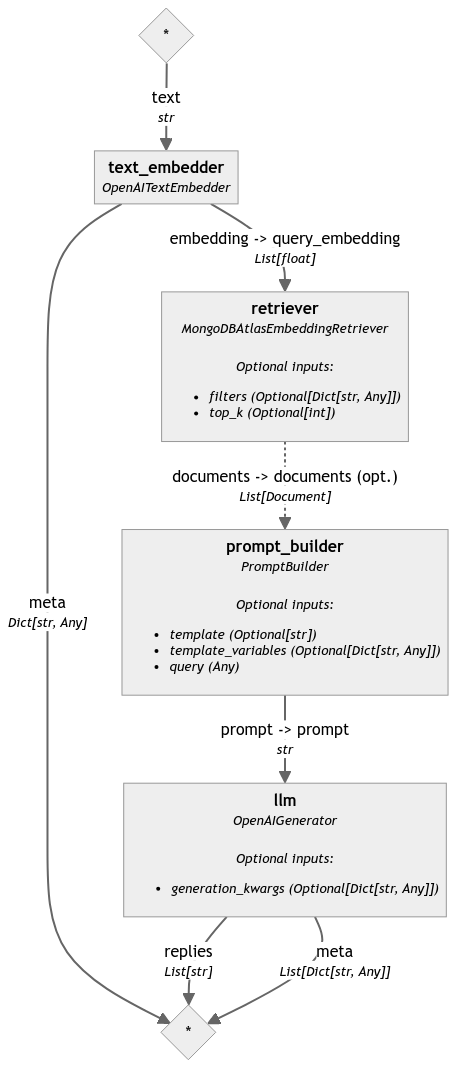

In [24]:
rag_pipeline.show()

Lets test the pipeline

In [12]:
query = "How can I cook a lasagne?"
result = rag_pipeline.run({"text_embedder": {"text": query},
                           "prompt_builder": {"query": query},
                           }, include_outputs_from=['retriever',  'prompt_builder'])
print(result['llm']['replies'][0])

To cook a lasagna, you'll need to follow several steps, including preparing the ingredients, making the sauce, assembling the lasagna, and baking it. Here's a comprehensive recipe that incorporates the ingredients available:

### Ingredients
- Lasagna sheets (choose from Spinach, Gluten-Free, or Whole Wheat)
- Your choice of sauces (Tomato Basil Sauce, Marinara Sauce, Arrabbiata Sauce, Pesto Sauce, Pesto Cream Sauce, Alfredo Sauce, Coconut Milk Béchamel, Vegan Cashew Cream Sauce)
- Your choice of cheese (Goat Cheese, Mascarpone, Cottage Cheese, Pecorino Romano, Grana Padano, Provolone Cheese, Tofu Ricotta, Vegan Mozzarella)
- Your choice of protein or meat substitutes (Bolognese Sauce, Chicken Bolognese, Turkey Bolognese, Vegetarian Lentil Sauce, Vegetarian Lentil Mince, Mushroom and Walnut Sauce, Mushroom and Walnut Mince, Vegan Soy Meat Sauce)
- Additional veggies (Spinach, Zucchini Slices, Eggplant Slices, Artichoke Hearts, Leeks)
- Flaxseed Meal or Chia Seeds (optional, for added t

## Customize the Pipeline to Include Prices

In [16]:
# Template for generating prompts for a movie recommendation engine.
prompt_template = """
    You are a recipe builder assistant. Below you have a list of ingredients followed by its price for each ingredient.
    Based on the requested food, provide a step by step recipe, followed by an itemized and total shopping list cost.

    Your recipe should have the following sections:
    - Ingredients
    - Steps
    - Cost

    {% for doc in documents %}
        Ingredient: {{ doc.content }}
        Price: {{ doc.meta['price']}}
    {% endfor %}

    \Query: {{query}}

    \nRecipe:
"""

# Setting up a retrieval-augmented generation (RAG) pipeline for generating responses.
rag_pipeline = Pipeline()
rag_pipeline.add_component("text_embedder", OpenAITextEmbedder())

# Adding a component for retrieving related documents from MongoDB based on the query embedding.
rag_pipeline.add_component(instance=MongoDBAtlasEmbeddingRetriever(document_store=document_store,top_k=50), name="retriever")

# Building prompts based on retrieved documents to be used for generating responses.
rag_pipeline.add_component(instance=PromptBuilder(template=prompt_template), name="prompt_builder")

# Adding a language model generator to produce the final text output.
rag_pipeline.add_component(instance=OpenAIGenerator(model="gpt-4o"), name="llm")

# Connecting the components of the RAG pipeline to ensure proper data flow.
rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever.documents", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")

<>:2: SyntaxWarning: invalid escape sequence '\Q'
<>:2: SyntaxWarning: invalid escape sequence '\Q'
/var/folders/1d/5tncpz951nxfybkkx7hsvhvm0000gn/T/ipykernel_29478/2056757671.py:2: SyntaxWarning: invalid escape sequence '\Q'
  prompt_template = """


🚅 Components
  - text_embedder: OpenAITextEmbedder
  - retriever: MongoDBAtlasEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [17]:
query = "How can I cook a lasagne?"
result = rag_pipeline.run(
                                {
                                    "text_embedder": {"text": query},
                                    "prompt_builder": {"query": query},
                                }, include_outputs_from=["prompt_builder"])
print(result['llm']['replies'][0])

### Recipe: Classic Vegetarian Lasagna

#### Ingredients:
- Eggplant Slices - $2.75
- Whole Wheat Lasagna Sheets - $3.00
- Goat Cheese - $4.00
- Vegetarian Lentil Sauce - $4.00
- Tomato Basil Sauce - $3.50
- Spinach - $2.00
- Garlic - $0.50
- Onion - $1.00
- Canola Oil - $3.50
- Provolone Cheese - $3.50

#### Steps:

1. **Prepare the Vegetables:**
   - Slice 1 eggplant into thin rounds.
   - Wash and chop 2 cups of spinach.
   - Dice 1 onion and mince 2 cloves of garlic.

2. **Cook the Eggplant:**
   - Heat a skillet over medium heat and add 2 tablespoons of canola oil.
   - Add the eggplant slices and cook until they are soft and lightly browned on both sides. Remove from the skillet and set aside.

3. **Make the Sauce:**
   - In the same skillet, add a bit more oil if necessary.
   - Add the diced onion and cook until translucent, about 5 minutes.
   - Add the minced garlic and cook for another minute.
   - Pour in the vegetarian lentil sauce and tomato basil sauce. Stir well.
   - L

## Make it cheaper with self-reflection!

In [37]:
!pip install colorama

  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)


In [47]:
from colorama import Fore
from typing import List
from haystack import component

@component
class RecipeChecker:
    
    @component.output_types(recipe_to_check=str, recipe=str)
    def run(self, replies: List[str]):
        if 'done' in replies[0]:
            return {"recipe":replies[0].replace('done', '')}
        else:
            print(Fore.RED + "Not done yet, could make recipe more efficient")
            return {"recipe_to_check": replies[0]}

In [48]:
# Template for generating prompts for a movie recommendation engine.
prompt_template = """
    You are a recipe builder assistant. Below you have a list of ingredients followed by its price for each ingredient.
    Based on the requested food, provide a step by step recipe, followed by an itemized and total shopping list cost.

    Your recipe should have the following sections:
    - Ingredients
    - Steps
    - Cost

    {% for doc in documents %}
        Ingredient: {{ doc.content }}
        Price: {{ doc.meta['price']}}
    {% endfor %}

    Query: {{query}}
    {% if recipe_to_check %}
        Here is the recipe you previously generated: {{recipe_to_check[0]}}
        Is this the most efficient and cheap way to do this recipe?
        If yes, say 'done' and return the recipe s in the next line
        If not, say 'incomplete' and return the recipe in the next line
    {% endif %}
    \nRecipe:
"""

reflecting_rag_pipeline = Pipeline(max_loops_allowed=5)
reflecting_rag_pipeline.add_component("text_embedder", OpenAITextEmbedder())
reflecting_rag_pipeline.add_component(instance=MongoDBAtlasEmbeddingRetriever(document_store=document_store,top_k=50), name="retriever")
reflecting_rag_pipeline.add_component(instance=PromptBuilder(template=prompt_template), name="prompt_builder")
reflecting_rag_pipeline.add_component(instance=RecipeChecker(), name="checker")
reflecting_rag_pipeline.add_component(instance=OpenAIGenerator(model="gpt-4o"), name="llm")

reflecting_rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
reflecting_rag_pipeline.connect("retriever.documents", "prompt_builder.documents")
reflecting_rag_pipeline.connect("checker.recipe_to_check", "prompt_builder.recipe_to_check")
reflecting_rag_pipeline.connect("prompt_builder", "llm")
reflecting_rag_pipeline.connect("llm", "checker")


🚅 Components
  - text_embedder: OpenAITextEmbedder
  - retriever: MongoDBAtlasEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - checker: RecipeChecker
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)
  - checker.recipe_to_check -> prompt_builder.recipe_to_check (str)
  - llm.replies -> checker.replies (List[str])

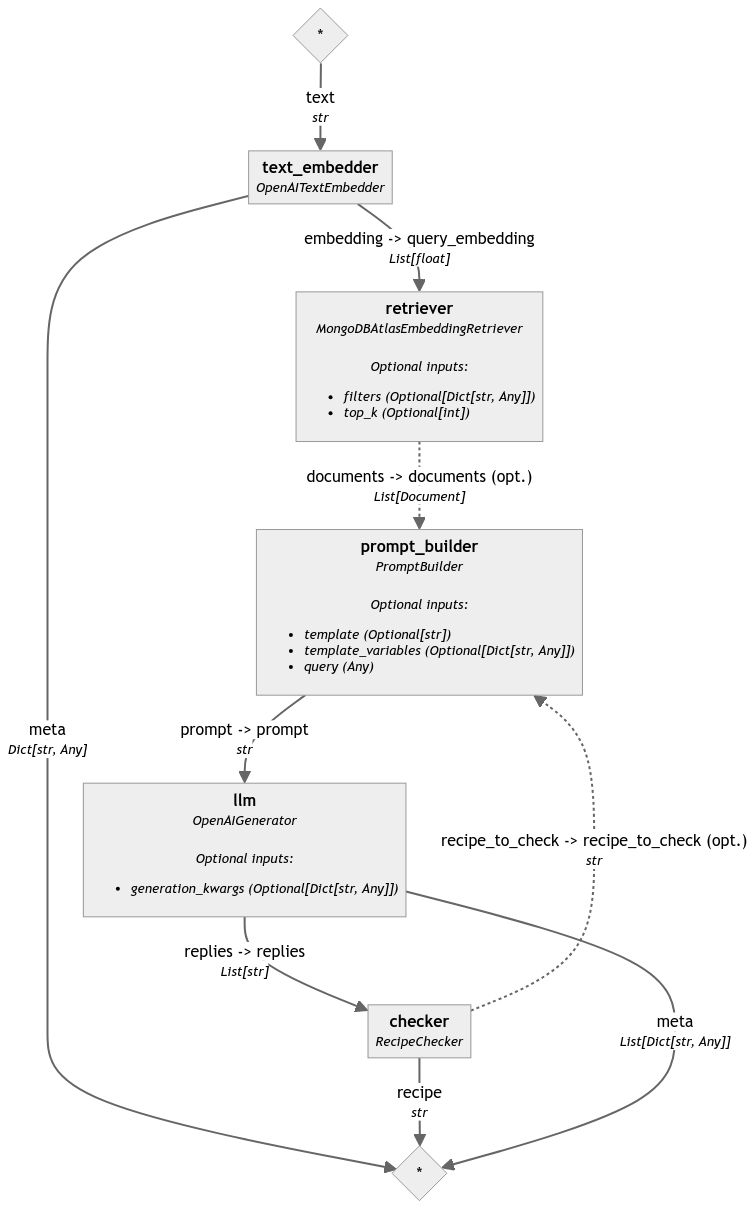

In [41]:
reflecting_rag_pipeline.show()

In [49]:
query = "How can I cook a lasagne?"
result = reflecting_rag_pipeline.run({"text_embedder": {"text": query},
                            "prompt_builder": {"query": query}})
print(Fore.GREEN + result["checker"]["recipe"])

Not done yet, could make recipe more efficient
Not done yet, could make recipe more efficient
**Vegetarian Lasagne Recipe:**

### Ingredients:
- 1 pack Spinach Lasagna Sheets ($3.50)
- 1 jar Tomato Basil Sauce ($3.50)
- 1 cup Cottage Cheese ($2.50)
- 1 cup Provolone Cheese ($3.50)
- 1 cup Spinach ($2.00)
- 1 large Eggplant Slices ($2.75)
- 1 cup Zucchini Slices ($2.50)
- 1 jar Marinara Sauce ($3.50)
- 1 Tofu Ricotta ($3.00)
- 2 cloves Garlic ($0.50)

### Steps:
1. **Prepare the Veggies:**
   - Preheat your oven to 375°F (190°C).
   - Slice the eggplant and zucchini into thin slices.
   
2. **Cooking the Veggies:**
   - Sauté the eggplant and zucchini slices in a pan with a bit of oil until they are slightly softened.
   
3. **Assemble the Lasagne:**
   - Spread a thin layer of Tomato Basil Sauce at the bottom of your baking dish.
   - Add a layer of spinach lasagna sheets.
   - Spread a layer of tofu ricotta and cottage cheese on top of the sheets.
   - Place some sautéed eggplant and 